# Day 12: Passage Pathing

## Part 1:

With your submarine's subterranean subsystems subsisting suboptimally, the only way you're getting out of this cave anytime soon is by finding a path yourself. Not just a path - the only way to know if you've found the best path is to find all of them.

Fortunately, the sensors are still mostly working, and so you build a rough map of the remaining caves (your puzzle input). For example:
```
start-A
start-b
A-c
A-b
b-d
A-end
b-end
```

This is a list of how all of the caves are connected. You start in the cave named start, and your destination is the cave named end. An entry like b-d means that cave b is connected to cave d - that is, you can move between them.

So, the above cave system looks roughly like this:
```
    start
    /   \
c--A-----b--d
    \   /
     end
```

Your goal is to find the number of distinct paths that start at start, end at end, and don't visit small caves more than once. There are two types of caves: big caves (written in uppercase, like A) and small caves (written in lowercase, like b). It would be a waste of time to visit any small cave more than once, but big caves are large enough that it might be worth visiting them multiple times. So, all paths you find should visit small caves at most once, and can visit big caves any number of times.

Given these rules, there are 10 paths through this example cave system:
```
start,A,b,A,c,A,end
start,A,b,A,end
start,A,b,end
start,A,c,A,b,A,end
start,A,c,A,b,end
start,A,c,A,end
start,A,end
start,b,A,c,A,end
start,b,A,end
start,b,end
```

(Each line in the above list corresponds to a single path; the caves visited by that path are listed in the order they are visited and separated by commas.)

Note that in this cave system, cave d is never visited by any path: to do so, cave b would need to be visited twice (once on the way to cave d and a second time when returning from cave d), and since cave b is small, this is not allowed.

Here is a slightly larger example:
```
dc-end
HN-start
start-kj
dc-start
dc-HN
LN-dc
HN-end
kj-sa
kj-HN
kj-dc
```

The 19 paths through it are as follows:
```
start,HN,dc,HN,end
start,HN,dc,HN,kj,HN,end
start,HN,dc,end
start,HN,dc,kj,HN,end
start,HN,end
start,HN,kj,HN,dc,HN,end
start,HN,kj,HN,dc,end
start,HN,kj,HN,end
start,HN,kj,dc,HN,end
start,HN,kj,dc,end
start,dc,HN,end
start,dc,HN,kj,HN,end
start,dc,end
start,dc,kj,HN,end
start,kj,HN,dc,HN,end
start,kj,HN,dc,end
start,kj,HN,end
start,kj,dc,HN,end
start,kj,dc,end
```

Finally, this even larger example has 226 paths through it:
```
fs-end
he-DX
fs-he
start-DX
pj-DX
end-zg
zg-sl
zg-pj
pj-he
RW-he
fs-DX
pj-RW
zg-RW
start-pj
he-WI
zg-he
pj-fs
start-RW
```

**How many paths through this cave system are there that visit small caves at most once?**

This is pretty clearly a graph (node, edge) problem. Time to learn how to create graphs! I'm going to use the [NetworkX](https://networkx.org/documentation/stable/tutorial.html) Python package.

In [5]:
import networkx as nx
import matplotlib as plt

There are multiple test input examples given this time, with increasing length/complexity. I'm going to start with the simplest first.

In [3]:
# Get test input
with open('./test_input_12-1.txt') as f:
    lines = f.readlines()
test_input = [line.strip() for line in lines]
test_input

['start-A', 'start-b', 'A-c', 'A-b', 'b-d', 'A-end', 'b-end']

I'm going to create a directed graph (`DiGraph()`) to account for `'start'` and `'end'`, plus maybe that will also help with the repetition of capital letter nodes. I'll set it so that capital letter nodes are bidirectional, while lower case nodes are not.

In [48]:
G = nx.DiGraph()
for pair in test_input:
    (x, y) = pair.split('-')
    G.add_edge(x, y)
    if (x.isupper() or y.isupper()) and x!='start' and y!='end':
        G.add_edge(y, x)

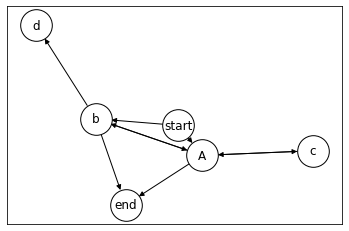

In [59]:
nx.draw_networkx(G, node_size=1000, node_color='white', edgecolors='black')

That's basically what the first simple example looked like as given, but I'm not sure if making it directed actually helped... 

Now, how to 'travel' the nodes?

In [75]:
list(G.edges)

[('start', 'A'),
 ('start', 'b'),
 ('A', 'c'),
 ('A', 'b'),
 ('A', 'end'),
 ('b', 'A'),
 ('b', 'd'),
 ('b', 'end'),
 ('c', 'A')]

In [61]:
print(list(nx.dfs_tree(G, source='start')))

['start', 'A', 'c', 'b', 'd', 'end']


In [62]:
print(list(nx.bfs_tree(G, source='start')))

['start', 'A', 'b', 'c', 'end', 'd']


In [67]:
list(G.nodes)

['start', 'A', 'b', 'c', 'd', 'end']

In [66]:
list(nx.all_simple_paths(G, source='start', target='end'))

[['start', 'A', 'b', 'end'],
 ['start', 'A', 'end'],
 ['start', 'b', 'A', 'end'],
 ['start', 'b', 'end']]

Not sure if this is actually helping me or if I just don't really know how to use it yet.

In [74]:
list(nx.generate_edgelist(G, data=False))

['start A', 'start b', 'A c', 'A b', 'A end', 'b A', 'b d', 'b end', 'c A']

In [84]:
list(nx.all_simple_paths(G, source='d', target='end'))

[]

In [87]:
list(G['A'])

['c', 'b', 'end']

From doing some research, I need to implement an algorithm that keeps track of 'visited' nodes (i.e., lowercase nodes).

Pseudocode solution:
 - Create a graph from the input text *(not sure it **needs** to be directed if I'm keeping track of visitors?)*
 - Start a 'start' node, get connected nodes
 - For each connected node:
  - Mark only lower-case nodes as 'visited'
  - Get connected nodes that are NOT 'visited'
  - If you get to 'end', add 1 to 'paths'
  
**Note:** I realized that the graph should *not* be directed because it's very possible to have a set of lowercase nodes that could be traversed in either direction: `A -- a -- b -- c -- A` for instance.

In [89]:
visited_dict = {node:False for node in list(G.nodes)}
visited_dict

{'start': False, 'A': False, 'b': False, 'c': False, 'd': False, 'end': False}

In [127]:
def make_graph(input_text):
    G = nx.Graph()
    for pair in input_text:
        (x, y) = pair.split('-')
        G.add_edge(x, y)
        if (x.isupper() or y.isupper()) and x!='start' and y!='end':
            G.add_edge(y, x)
    return G
# With help from https://www.geeksforgeeks.org/count-possible-paths-two-vertices/
def count_paths(G, start, visited, paths):
    if start=='end':
        paths[0] += 1
        return
    
    if start.islower():
        visited.append(start)
    
    for node in list(G[start]):
        if node not in visited:
            count_paths(G, node, visited, paths)
    
    if start in visited:
        visited.remove(start)
            
def solution(input_text):
    G = make_graph(input_text)

    visited = []
    paths = [0]
    
    count_paths(G, 'start', visited, paths)
    
    return paths

In [ ]:
visited_dict = {node:False for node in list(G.nodes)}

In [126]:
solution(test_input)

[10]

Great, now to try it on the other test inputs.

In [135]:
# Get test input
with open('./test_input_12-2.txt') as f:
    lines = f.readlines()
test2 = [line.strip() for line in lines]
with open('./test_input_12-3.txt') as f:
    lines = f.readlines()
test3 = [line.strip() for line in lines]

In [136]:
test2

['dc-end',
 'HN-start',
 'start-kj',
 'dc-start',
 'dc-HN',
 'LN-dc',
 'HN-end',
 'kj-sa',
 'kj-HN',
 'kj-dc']

In [137]:
solution(test2)
# 19

[19]

In [138]:
solution(test3)
# 226

[226]

In [139]:
# Get full input
with open('./input_12.txt') as f:
    lines = f.readlines()
full_input = [line.strip() for line in lines]

In [140]:
solution(full_input)

[4241]

## Part 2:

After reviewing the available paths, you realize you might have time to visit a single small cave twice. Specifically, big caves can be visited any number of times, a single small cave can be visited at most twice, and the remaining small caves can be visited at most once. However, the caves named start and end can only be visited exactly once each: once you leave the start cave, you may not return to it, and once you reach the end cave, the path must end immediately.

Now, the 36 possible paths through the first example above are:
```
start,A,b,A,b,A,c,A,end
start,A,b,A,b,A,end
start,A,b,A,b,end
start,A,b,A,c,A,b,A,end
start,A,b,A,c,A,b,end
start,A,b,A,c,A,c,A,end
start,A,b,A,c,A,end
start,A,b,A,end
start,A,b,d,b,A,c,A,end
start,A,b,d,b,A,end
start,A,b,d,b,end
start,A,b,end
start,A,c,A,b,A,b,A,end
start,A,c,A,b,A,b,end
start,A,c,A,b,A,c,A,end
start,A,c,A,b,A,end
start,A,c,A,b,d,b,A,end
start,A,c,A,b,d,b,end
start,A,c,A,b,end
start,A,c,A,c,A,b,A,end
start,A,c,A,c,A,b,end
start,A,c,A,c,A,end
start,A,c,A,end
start,A,end
start,b,A,b,A,c,A,end
start,b,A,b,A,end
start,b,A,b,end
start,b,A,c,A,b,A,end
start,b,A,c,A,b,end
start,b,A,c,A,c,A,end
start,b,A,c,A,end
start,b,A,end
start,b,d,b,A,c,A,end
start,b,d,b,A,end
start,b,d,b,end
start,b,end
```

The slightly larger example above now has 103 paths through it, and the even larger example now has 3509 paths through it.

Given these new rules, **how many paths through this cave system are there?**

